Training on: cpu


c:\Users\rohit\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rohit\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 2500/2500 [1:01:16<00:00,  1.47s/it, loss=26.9]



Epoch 1:
Loss: 22.2847 | RMSE: 49.1496 | Mean Error: 39.4195
Accuracy: 0.6201 | F1 Score: 0.9887
Confusion Matrix:
 [[18991   692]
 [    0 30307]]


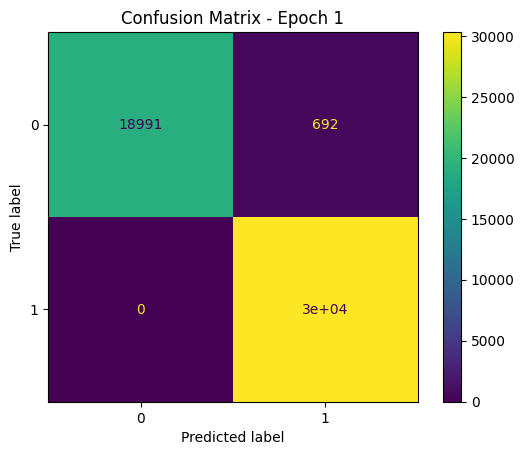

Model improved. Saved at: model_best.pth


Epoch 2/5: 100%|██████████| 2500/2500 [59:09<00:00,  1.42s/it, loss=21.5]



Epoch 2:
Loss: 21.8206 | RMSE: 48.6831 | Mean Error: 38.4951
Accuracy: 0.6240 | F1 Score: 0.9869
Confusion Matrix:
 [[18798   808]
 [    0 30384]]


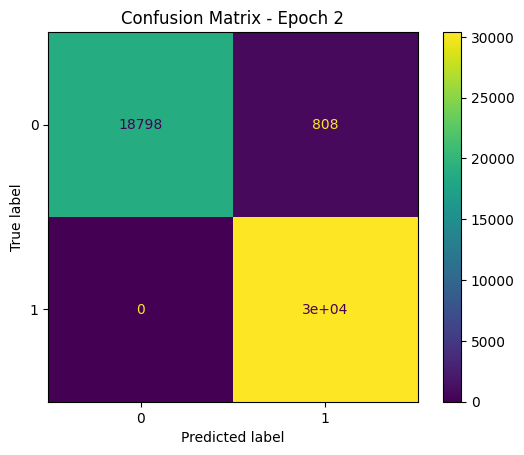

Model improved. Saved at: model_best.pth


Epoch 3/5: 100%|██████████| 2500/2500 [59:27<00:00,  1.43s/it, loss=25.8] 



Epoch 3:
Loss: 21.5226 | RMSE: 48.5075 | Mean Error: 37.8986
Accuracy: 0.6268 | F1 Score: 0.9848
Confusion Matrix:
 [[18658   938]
 [    0 30394]]


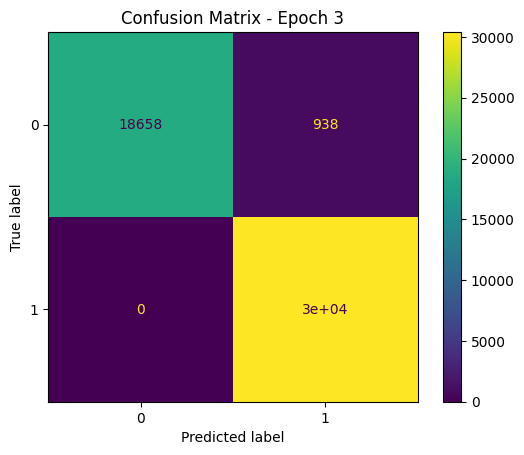

Model improved. Saved at: model_best.pth


Epoch 4/5: 100%|██████████| 2500/2500 [59:22<00:00,  1.42s/it, loss=14.5] 



Epoch 4:
Loss: 21.4043 | RMSE: 48.4552 | Mean Error: 37.6654
Accuracy: 0.6278 | F1 Score: 0.9849
Confusion Matrix:
 [[18607   932]
 [    0 30451]]


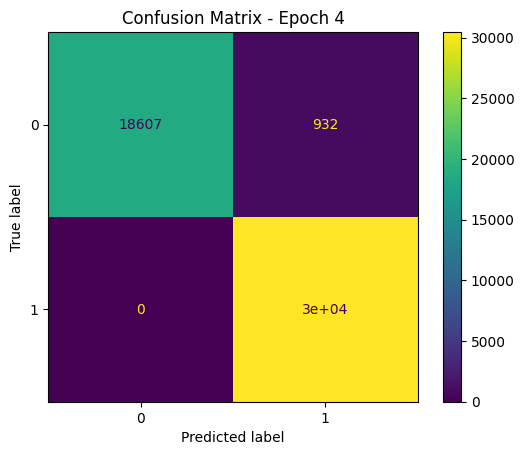

Model improved. Saved at: model_best.pth


Epoch 5/5: 100%|██████████| 2500/2500 [58:17<00:00,  1.40s/it, loss=26.9] 



Epoch 5:
Loss: 21.2237 | RMSE: 48.0644 | Mean Error: 37.2951
Accuracy: 0.6295 | F1 Score: 0.9836
Confusion Matrix:
 [[18522  1016]
 [    0 30452]]


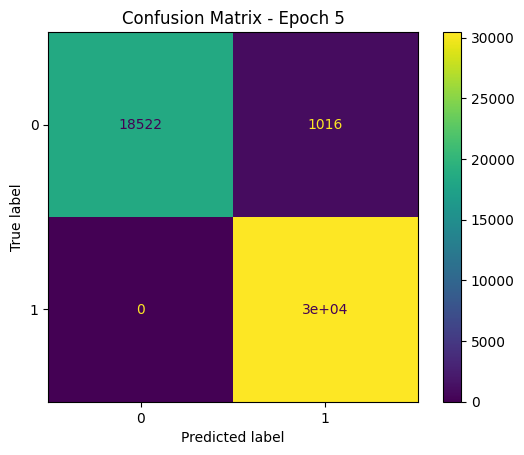

Model improved. Saved at: model_best.pth


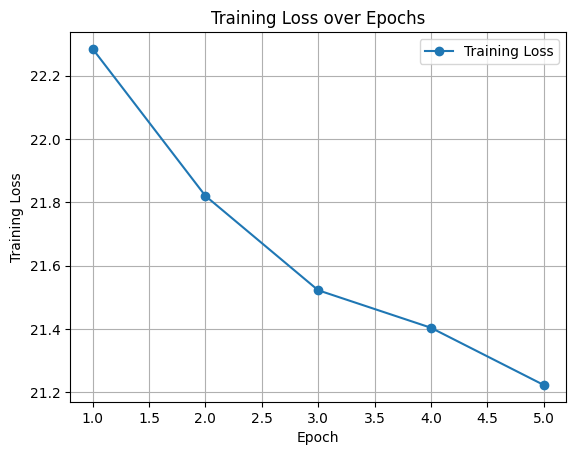

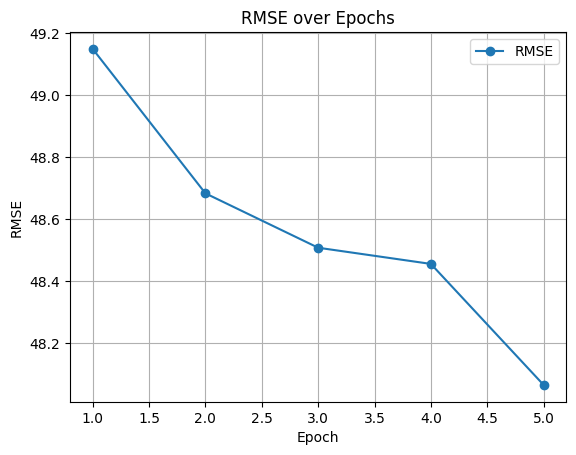

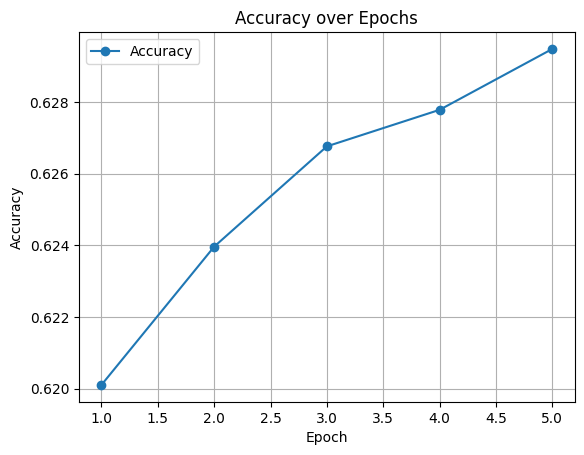

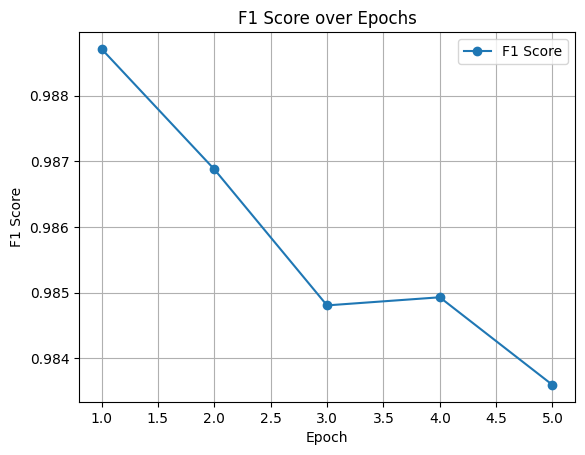

In [2]:
import os
import gc
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.models import mobilenet_v2
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# ---------- CONFIG ----------
NUM_KEYPOINTS = 5
INPUT_SIZE = (224, 224)
BATCH_SIZE = 4
EPOCHS = 5
MODEL_PATH = "model_best.pth"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {DEVICE}")

# ---------- DATASET ----------
class CubeSatDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(os.path.join(self.image_dir, row['IMG_NUM'])).convert('RGB')
        keypoints = np.array([float(x) for x in row[1:1 + NUM_KEYPOINTS * 2]]).reshape(NUM_KEYPOINTS, 2)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(keypoints, dtype=torch.float32)

# ---------- MODEL ----------
class KeypointNet(nn.Module):
    def __init__(self, num_keypoints=NUM_KEYPOINTS):
        super(KeypointNet, self).__init__()
        base = mobilenet_v2(pretrained=True)
        self.backbone = base.features
        for param in self.backbone.parameters():
            param.requires_grad = True

        self.conv = nn.Sequential(
            nn.Conv2d(1280, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(512, num_keypoints * 2)
        self._init_weights()

    def _init_weights(self):
        nn.init.kaiming_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)

    def forward(self, x):
        x = self.backbone(x)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.view(-1, NUM_KEYPOINTS, 2)

# ---------- METRICS ----------
def compute_metrics(preds, targets):
    mse = np.mean((preds - targets) ** 2)
    rmse = np.sqrt(mse)
    mean_error = np.mean(np.linalg.norm(preds - targets, axis=2))
    flat_dist = np.linalg.norm(preds - targets, axis=2).flatten()
    acc = np.mean(flat_dist <= 15)
    true_labels = (flat_dist <= 5).astype(int)
    pred_labels = (flat_dist <= 15).astype(int)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    cm = confusion_matrix(true_labels, pred_labels)
    return mse, rmse, mean_error, acc, f1, cm

# ---------- TRAIN ----------
def train_model(model, dataloader, optimizer, criterion, scheduler):
    metrics = {"epoch": [], "loss": [], "rmse": [], "accuracy": [], "f1_score": []}
    best_acc = 0.0

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        all_preds, all_targets = [], []
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for imgs, kps in loop:
            imgs, kps = imgs.to(DEVICE), kps.to(DEVICE)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, kps)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 2.0)  # gradient clipping
            optimizer.step()
            total_loss += loss.item()
            all_preds.append(out.detach().cpu().numpy())
            all_targets.append(kps.cpu().numpy())
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(dataloader)
        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)
        mse, rmse, mean_error, acc, f1, cm = compute_metrics(all_preds, all_targets)

        print(f"\nEpoch {epoch+1}:")
        print(f"Loss: {avg_loss:.4f} | RMSE: {rmse:.4f} | Mean Error: {mean_error:.4f}")
        print(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")
        print("Confusion Matrix:\n", cm)

        ConfusionMatrixDisplay(cm).plot()
        plt.title(f"Confusion Matrix - Epoch {epoch+1}")
        plt.show()

        metrics["epoch"].append(epoch + 1)
        metrics["loss"].append(avg_loss)
        metrics["rmse"].append(rmse)
        metrics["accuracy"].append(acc)
        metrics["f1_score"].append(f1)

        if acc > best_acc:
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"Model improved. Saved at: {MODEL_PATH}")
            best_acc = acc

        scheduler.step()
        gc.collect()
        torch.cuda.empty_cache()

    # Metric plots
    for key, label in {
        "loss": "Training Loss",
        "rmse": "RMSE",
        "accuracy": "Accuracy",
        "f1_score": "F1 Score"
    }.items():
        plt.figure()
        plt.plot(metrics["epoch"], metrics[key], marker='o', label=label)
        plt.xlabel("Epoch")
        plt.ylabel(label)
        plt.title(f"{label} over Epochs")
        plt.grid(True)
        plt.legend()
        plt.show()

# ---------- MAIN ----------
if __name__ == "__main__":
    transform = T.Compose([
        T.Resize(INPUT_SIZE),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        T.ColorJitter(0.3, 0.3, 0.3, 0.1),
        T.ToTensor()
    ])

    train_dataset = CubeSatDataset(
        image_dir='C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/train/images',
        csv_file='C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/train/train_ground_truth.csv',
        transform=transform
    )

    test_dataset = CubeSatDataset(
        image_dir='C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/test/images',
        csv_file='C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/test/test_ground_truth.csv',
        transform=transform
    )

    full_dataset = ConcatDataset([train_dataset, test_dataset])
    dataloader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

    model = KeypointNet().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    criterion = nn.SmoothL1Loss()

    train_model(model, dataloader, optimizer, criterion, scheduler)


Training on: cpu


c:\Users\rohit\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rohit\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 1250/1250 [1:10:33<00:00,  3.39s/it, loss=2.01e+3]



Epoch 1:
MSE: 2432.5613, RMSE: 49.3210
Mean Error: 39.7144
Accuracy: 0.7239, F1 Score: 0.5218
Confusion Matrix:
[[57321  7195]
 [20405 15059]]


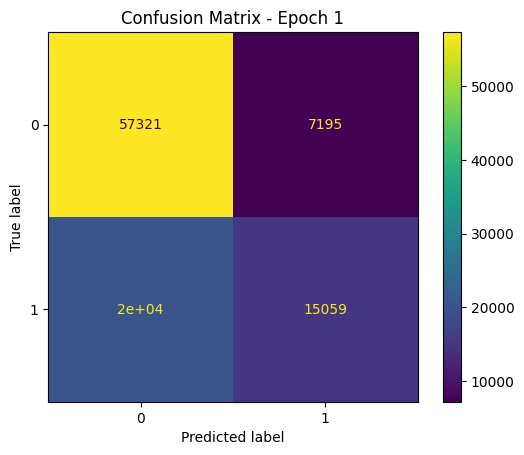

Epoch 2/5: 100%|██████████| 1250/1250 [39:50<00:00,  1.91s/it, loss=2.37e+3] 



Epoch 2:
MSE: 2425.6543, RMSE: 49.2509
Mean Error: 39.6226
Accuracy: 0.7406, F1 Score: 0.5572
Confusion Matrix:
[[57735  6781]
 [19151 16313]]


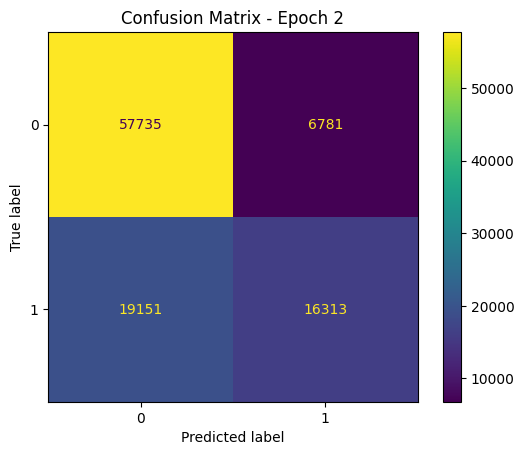

Epoch 3/5: 100%|██████████| 1250/1250 [28:40<00:00,  1.38s/it, loss=2.76e+3]



Epoch 3:
MSE: 2414.8555, RMSE: 49.1412
Mean Error: 39.4713
Accuracy: 0.7463, F1 Score: 0.5722
Confusion Matrix:
[[57656  6860]
 [18504 16960]]


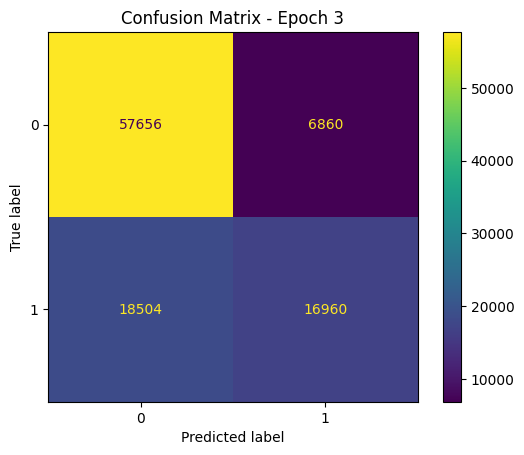

Epoch 4/5: 100%|██████████| 1250/1250 [28:20<00:00,  1.36s/it, loss=1.59e+3]



Epoch 4:
MSE: 2402.3845, RMSE: 49.0141
Mean Error: 39.3012
Accuracy: 0.7488, F1 Score: 0.5936
Confusion Matrix:
[[56515  8001]
 [17117 18347]]


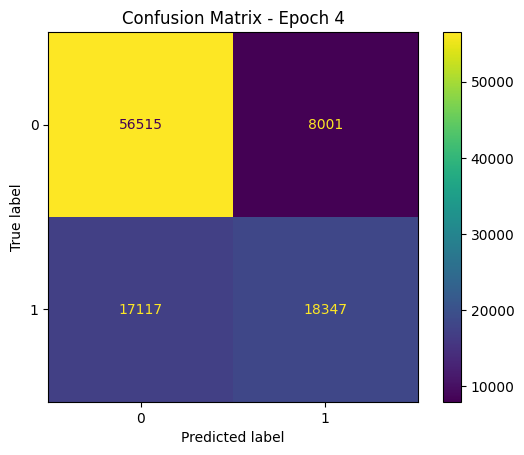

Epoch 5/5: 100%|██████████| 1250/1250 [28:59<00:00,  1.39s/it, loss=2.67e+3]



Epoch 5:
MSE: 2389.0696, RMSE: 48.8781
Mean Error: 39.1252
Accuracy: 0.7504, F1 Score: 0.5900
Confusion Matrix:
[[57059  7457]
 [17502 17962]]


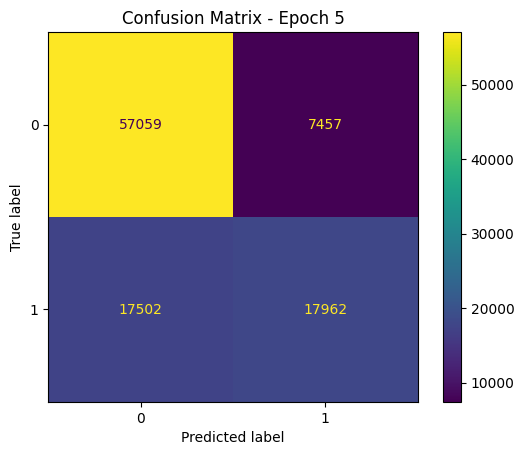

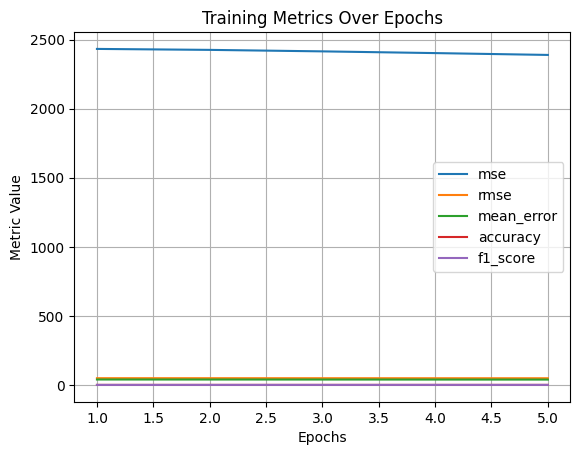

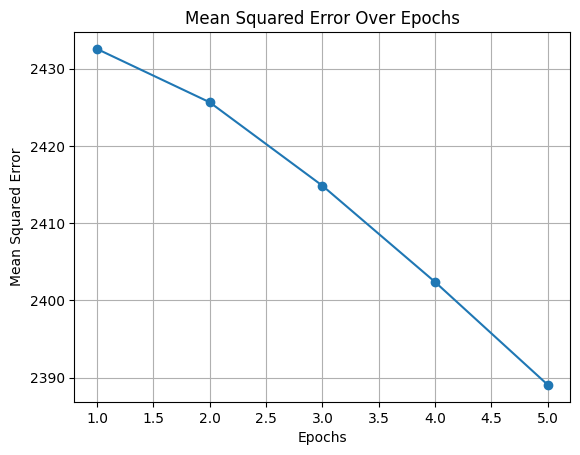

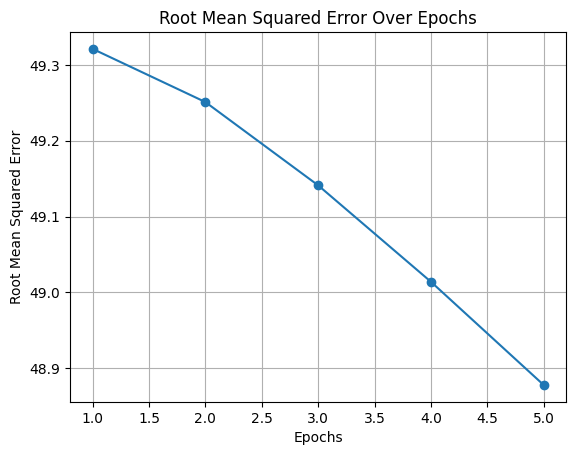

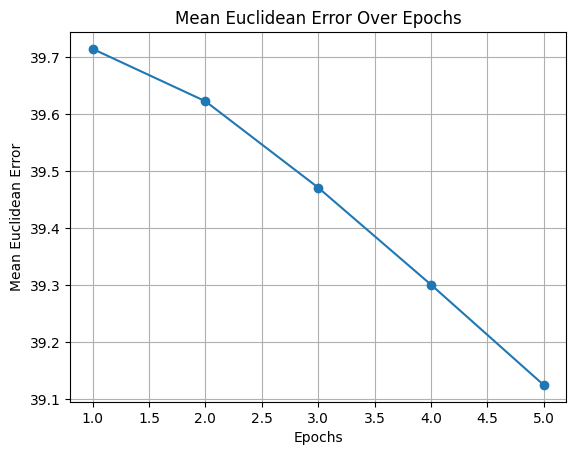

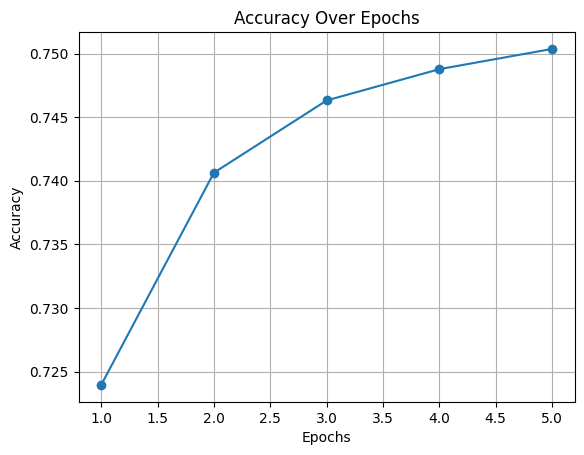

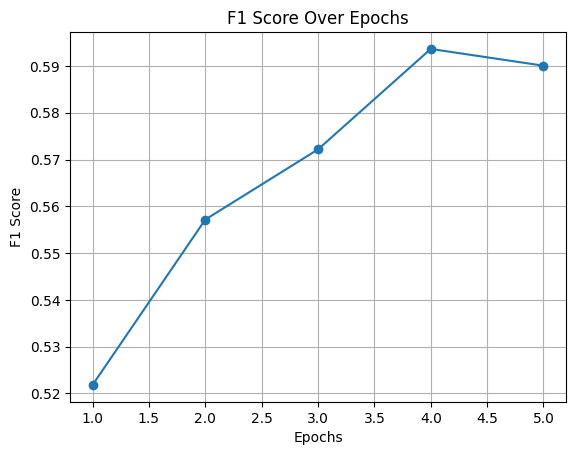

Model saved as 'keypointnet_cubesat.pth'


In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.models import mobilenet_v2
import torchvision.transforms as T
import torch.nn as nn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# ---------- CONFIG ----------
NUM_KEYPOINTS = 5
INPUT_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {DEVICE}")

# ---------- DATASET ----------
class CubeSatDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row['IMG_NUM'])
        image = Image.open(image_path).convert('RGB')
        keypoints = np.array([float(x) for x in row[1:1 + NUM_KEYPOINTS * 2]]).reshape(NUM_KEYPOINTS, 2)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(keypoints, dtype=torch.float32), row['IMG_NUM']

# ---------- MODEL ----------
class KeypointNet(nn.Module):
    def __init__(self, num_keypoints=NUM_KEYPOINTS):
        super(KeypointNet, self).__init__()
        base = mobilenet_v2(pretrained=True)
        self.backbone = base.features
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.conv = nn.Sequential(
            nn.Conv2d(1280, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(256, num_keypoints * 2)

    def forward(self, x):
        x = self.backbone(x)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.view(-1, NUM_KEYPOINTS, 2)

# ---------- METRICS ----------
def compute_metrics(preds, targets):
    mse = np.mean((preds - targets) ** 2)
    rmse = np.sqrt(mse)
    mean_error = np.mean(np.linalg.norm(preds - targets, axis=2))
    acc = accuracy_score((targets > 0.5).reshape(-1), (preds > 0.5).reshape(-1))
    f1 = f1_score((targets > 0.5).reshape(-1), (preds > 0.5).reshape(-1), zero_division=0)
    cm = confusion_matrix((targets > 0.5).reshape(-1), (preds > 0.5).reshape(-1))
    return mse, rmse, mean_error, acc, f1, cm

# ---------- TRAINING LOOP ----------
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    metrics = {
        "epoch": [],
        "mse": [],
        "rmse": [],
        "mean_error": [],
        "accuracy": [],
        "f1_score": []
    }

    for epoch in range(EPOCHS):
        total_loss = 0
        all_preds, all_targets = [], []
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for imgs, kps, _ in loop:
            imgs, kps = imgs.to(DEVICE), kps.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, kps)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            all_preds.append(outputs.detach().cpu().numpy())
            all_targets.append(kps.cpu().numpy())
            loop.set_postfix(loss=loss.item())

        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)
        mse, rmse, mean_error, acc, f1, cm = compute_metrics(all_preds, all_targets)

        print(f"\nEpoch {epoch+1}:")
        print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}")
        print(f"Mean Error: {mean_error:.4f}")
        print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")

        ConfusionMatrixDisplay(cm).plot()
        plt.title(f"Confusion Matrix - Epoch {epoch+1}")
        plt.grid(False)
        plt.show()

        # Save metrics
        metrics["epoch"].append(epoch + 1)
        metrics["mse"].append(mse)
        metrics["rmse"].append(rmse)
        metrics["mean_error"].append(mean_error)
        metrics["accuracy"].append(acc)
        metrics["f1_score"].append(f1)

    # Plot all metrics on one graph
    plt.figure()
    for key in ["mse", "rmse", "mean_error", "accuracy", "f1_score"]:
        plt.plot(metrics["epoch"], metrics[key], label=key)
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.title("Training Metrics Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Individual plots
    metric_names = {
        "mse": "Mean Squared Error",
        "rmse": "Root Mean Squared Error",
        "mean_error": "Mean Euclidean Error",
        "accuracy": "Accuracy",
        "f1_score": "F1 Score"
    }

    for key, label in metric_names.items():
        plt.figure()
        plt.plot(metrics["epoch"], metrics[key], marker='o', linestyle='-')
        plt.xlabel("Epochs")
        plt.ylabel(label)
        plt.title(f"{label} Over Epochs")
        plt.grid(True)
        plt.show()

# ---------- MAIN ----------
if __name__ == "__main__":
    transform = T.Compose([
        T.Resize(INPUT_SIZE),
        T.ToTensor()
    ])

    train_dataset = CubeSatDataset(
        image_dir='C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/train/images',
        csv_file='C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/train/train_ground_truth.csv',
        transform=transform
    )

    test_dataset = CubeSatDataset(
        image_dir='C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/test/images',
        csv_file='C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/test/test_ground_truth.csv',
        transform=transform
    )

    full_dataset = ConcatDataset([train_dataset, test_dataset])
    dataloader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = KeypointNet().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    train_model(model, dataloader, optimizer, criterion)

    torch.save(model.state_dict(), "keypointnet_cubesat.pth")
    print("Model saved as 'keypointnet_cubesat.pth'")


Running SL(3) Observer on TRAIN+TEST combined


Observer Running: 100%|██████████| 9997/9997 [2:34:23<00:00,  1.08it/s]  



[TRAIN_TEST_COMBINED] MEAN ER: 2.2060, ET: 0.6255, EC: 2.8315
Total samples: 5251, Good (<0.75): 20, Bad: 5231
Accuracy: 1.0000
F1 Score: 1.0000
MSE: 0.0000, RMSE: 0.0000
Confusion Matrix:
[[5231    0]
 [   0   20]]


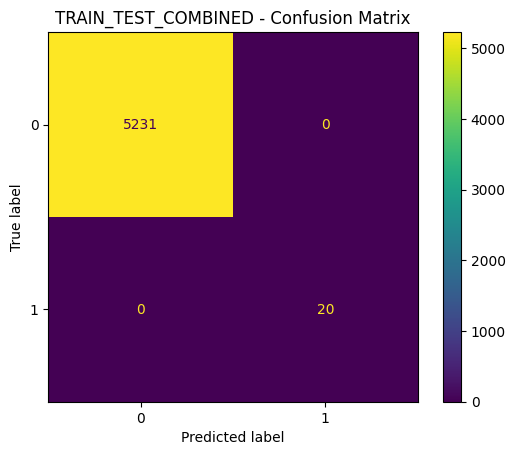

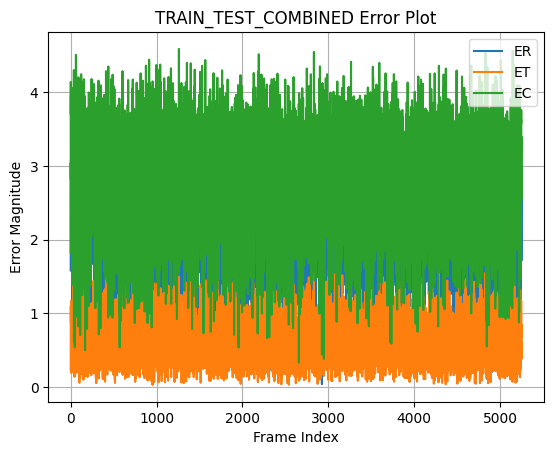

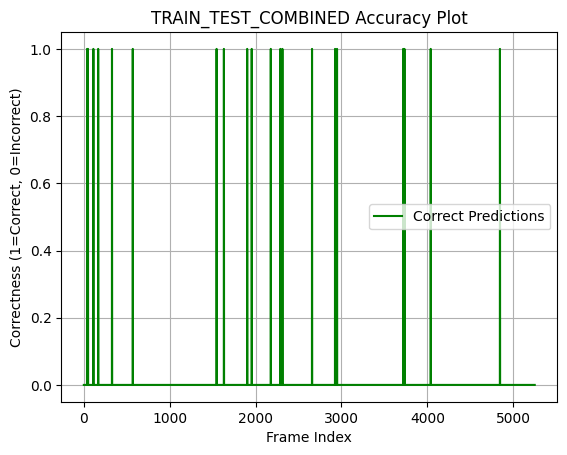


Running SL(3) Observer on SEQUENCE A+B+C


Observer Running:  21%|██        | 2259/10793 [36:23<2:06:43,  1.12it/s]C:\Users\rohit\AppData\Local\Temp\ipykernel_9672\1169279238.py:20: RuntimeWarning: divide by zero encountered in divide
  return H / np.cbrt(np.linalg.det(H))
Observer Running:  21%|██        | 2260/10793 [36:24<2:07:35,  1.11it/s]C:\Users\rohit\AppData\Local\Temp\ipykernel_9672\1169279238.py:78: RuntimeWarning: invalid value encountered in divide
  p_hat = p_hat / np.linalg.norm(p_hat)
C:\Users\rohit\AppData\Local\Temp\ipykernel_9672\1169279238.py:121: RuntimeWarning: invalid value encountered in matmul
  H_dot = H_hat @ Omega - delta @ H_hat
c:\Users\rohit\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\linalg\_linalg.py:2383: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
Observer Running:  21%|██        | 2261/10793 [36:25<2:13:14,  1.07it/s]c:\Users\rohit\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\linalg\_linalg.py:2383: Run


[SEQUENCE_ABC_COMBINED] MEAN ER: 0.0042, ET: 0.0003, EC: 0.0045
Total samples: 10793, Good (<0.75): 10791, Bad: 2
Accuracy: 1.0000
F1 Score: 1.0000
MSE: 0.0000, RMSE: 0.0000
Confusion Matrix:
[[    2     0]
 [    0 10791]]


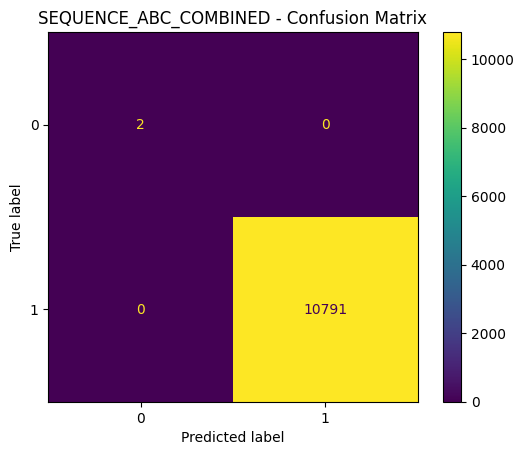

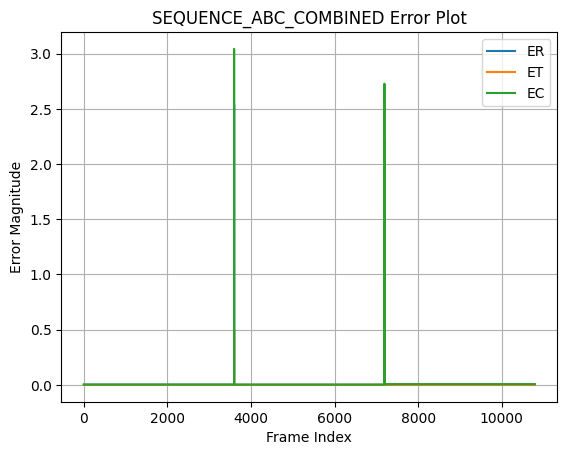

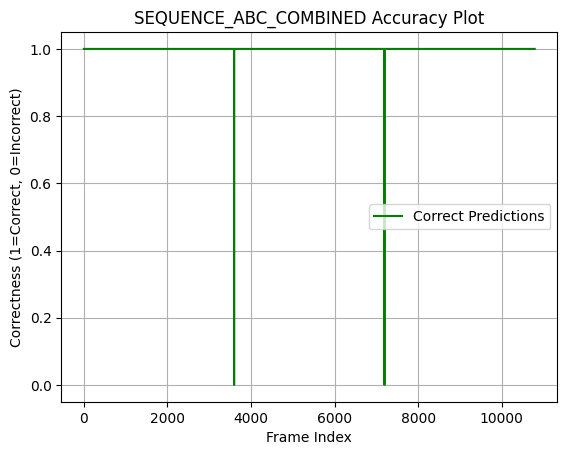


[FINISHED] All observer runs completed.


In [2]:
# ========================== SL(3) OBSERVER CODE ==========================
import os
import cv2
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

cv2.setNumThreads(4)

# ---------- Helper Functions ----------
def skew(w):
    return np.array([[0, -w[2], w[1]],
                     [w[2], 0, -w[0]],
                     [-w[1], w[0], 0]])

def normalize_H(H):
    return H / np.cbrt(np.linalg.det(H))

def project_to_SL3(H):
    return normalize_H(H)

def resize_img(img, scale=0.5):
    return cv2.resize(img, (0, 0), fx=scale, fy=scale)

def get_correspondences(img1, img2, max_points=150):
    sift = cv2.SIFT_create(nfeatures=300)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    if des1 is None or des2 is None or len(des1) < 2 or len(des2) < 2:
        return np.zeros((3, 0)), np.zeros((3, 0))

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=100)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    try:
        matches = flann.knnMatch(des1, des2, k=2)
    except cv2.error:
        return np.zeros((3, 0)), np.zeros((3, 0))

    good_matches = []
    for match in matches:
        if len(match) == 2:
            m, n = match
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

    if len(good_matches) < 4:
        return np.zeros((3, 0)), np.zeros((3, 0))

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 0.5)
    if mask is None:
        return np.zeros((3, 0)), np.zeros((3, 0))

    mask = mask.ravel().astype(bool)
    src_pts = src_pts[mask][:max_points]
    dst_pts = dst_pts[mask][:max_points]

    src_pts = np.hstack([src_pts.squeeze(), np.ones((src_pts.shape[0], 1))]).T
    dst_pts = np.hstack([dst_pts.squeeze(), np.ones((dst_pts.shape[0], 1))]).T
    return src_pts, dst_pts

def compute_delta(H, ref_pts, cur_pts, k=1.0):
    n = ref_pts.shape[1]
    delta = np.zeros((3, 3))
    for i in range(n):
        p = ref_pts[:, i]
        p_hat = H @ cur_pts[:, i]
        p_hat = p_hat / np.linalg.norm(p_hat)
        proj = np.eye(3) - np.outer(p_hat, p_hat)
        delta += k * proj @ np.outer(p, p_hat.T)
    delta = -delta
    delta -= np.eye(3) * np.trace(delta) / 3
    return delta

def run_sl3_observer(folders, csv_files, scale=0.5):
    df_list = [pd.read_csv(csv) for csv in csv_files]
    df = pd.concat(df_list, ignore_index=True)
    img_dirs = [os.path.abspath(f) for f in folders]

    H_hat = np.eye(3)
    ER, ET, EC = [], [], []

    for i in tqdm(range(len(df) - 1), desc="Observer Running"):
        folder_idx = 0 if i < len(df_list[0]) - 1 else 1 if len(folders) > 1 else 0
        img_dir = img_dirs[folder_idx]

        img1_path = os.path.join(img_dir, df.iloc[i]['IMG_NUM'])
        img2_path = os.path.join(img_dir, df.iloc[i + 1]['IMG_NUM'])

        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)

        if img1 is None or img2 is None:
            continue

        img1 = resize_img(img1, scale)
        img2 = resize_img(img2, scale)

        q1 = df.iloc[i][['Q1', 'Q2', 'Q3', 'W']].values
        q2 = df.iloc[i + 1][['Q1', 'Q2', 'Q3', 'W']].values
        r1 = R.from_quat(q1)
        r2 = R.from_quat(q2)
        omega = (r2 * r1.inv()).as_rotvec()
        Omega = skew(omega)

        p1, p2 = get_correspondences(img1, img2)
        if p1.ndim != 2 or p1.shape[1] < 4:
            continue

        delta = compute_delta(H_hat, p1, p2)
        H_dot = H_hat @ Omega - delta @ H_hat
        H_hat += 0.05 * H_dot
        H_hat = project_to_SL3(H_hat)

        t1 = df.iloc[i][['X', 'Y', 'Z']].values
        t2 = df.iloc[i + 1][['X', 'Y', 'Z']].values
        dt = np.linalg.norm(t2 - t1)
        er = np.linalg.norm(omega)
        ec = er + dt

        ER.append(er)
        ET.append(dt)
        EC.append(ec)

    return ER, ET, EC

def evaluate_and_plot(name, ER, ET, EC):
    print(f"\n[{name.upper()}] MEAN ER: {np.mean(ER):.4f}, ET: {np.mean(ET):.4f}, EC: {np.mean(EC):.4f}")

    ec_threshold = 0.75
    binary_labels = np.array(EC) < ec_threshold
    predictions = binary_labels

    acc = accuracy_score(binary_labels, predictions)
    f1 = f1_score(binary_labels, predictions)
    cm = confusion_matrix(binary_labels, predictions)
    mse = mean_squared_error(binary_labels.astype(int), predictions.astype(int))
    rmse = np.sqrt(mse)

    print(f"Total samples: {len(EC)}, Good (<{ec_threshold}): {np.sum(binary_labels)}, Bad: {np.sum(~binary_labels)}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name.upper()} - Confusion Matrix")
    plt.show()

    plt.figure()
    plt.plot(ER, label='ER')
    plt.plot(ET, label='ET')
    plt.plot(EC, label='EC')
    plt.xlabel('Frame Index')
    plt.ylabel('Error Magnitude')
    plt.title(f"{name.upper()} Error Plot")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(np.arange(len(EC)), binary_labels.astype(int), label='Correct Predictions', color='green')
    plt.xlabel('Frame Index')
    plt.ylabel('Correctness (1=Correct, 0=Incorrect)')
    plt.title(f"{name.upper()} Accuracy Plot")
    plt.legend()
    plt.grid()
    plt.show()

def main():
    print("Running SL(3) Observer on TRAIN+TEST combined")
    train_folder = "C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/train/images"
    test_folder = "C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/test/images"
    train_csv = "C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/train/train_ground_truth.csv"
    test_csv = "C:/Users/rohit/Downloads/archive/synthetic_cubesat/dataset/test/test_ground_truth.csv"

    ER, ET, EC = run_sl3_observer([train_folder, test_folder], [train_csv, test_csv])
    evaluate_and_plot("train_test_combined", ER, ET, EC)

    print("\nRunning SL(3) Observer on SEQUENCE A+B+C")
    seq_a_folder = "C:/Users/rohit/Downloads/archive/synthetic_cubesat/sequence_a/images"
    seq_b_folder = "C:/Users/rohit/Downloads/archive/synthetic_cubesat/sequence_b/images"
    seq_c_folder = "C:/Users/rohit/Downloads/archive/synthetic_cubesat/sequence_c/images"
    seq_a_csv = "C:/Users/rohit/Downloads/archive/synthetic_cubesat/sequence_a/ground_truth.csv"
    seq_b_csv = "C:/Users/rohit/Downloads/archive/synthetic_cubesat/sequence_b/ground_truth.csv"
    seq_c_csv = "C:/Users/rohit/Downloads/archive/synthetic_cubesat/sequence_c/ground_truth.csv"

    ER_seq, ET_seq, EC_seq = run_sl3_observer(
        [seq_a_folder, seq_b_folder, seq_c_folder],
        [seq_a_csv, seq_b_csv, seq_c_csv]
    )
    evaluate_and_plot("sequence_abc_combined", ER_seq, ET_seq, EC_seq)

    print("\n[FINISHED] All observer runs completed.")

if __name__ == '__main__':
    main()
